# Covid-19 Report

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import statsmodels.api as sm

In [2]:
# ETL JHU data
!python Data-Processing.py

Processing 05-21-2020.csv
Processing 05-20-2020.csv
(2916, 12)


In [3]:
data = pd.read_excel('covid_19_US.xlsx')
print('Total confirmed cases:', data.Confirmed.sum())
print('Total deaths cases:', data.Deaths.sum())
data.query("County in ('New York', 'Alameda', 'Los Angeles', 'Ventura', 'Union', 'Santa Clara') and State in ('California', 'New York', 'New Jersey')")

Total confirmed cases: 1560025
Total deaths cases: 93438


,FIPS,County,State,Confirmed,Deaths,Recovered,Confirmed_new,Deaths_new,Recovered_new,Confirmed_rate,Deaths_rate,Recovered_rate
171,6001,Alameda,California,2609,90,0,49,2,0.0,0.001582,0.034496,0.0
188,6037,Los Angeles,California,42037,2016,0,1142,43,0.0,0.004166,0.047958,0.0
211,6085,Santa Clara,California,2492,138,0,0,0,0.0,0.001312,0.055377,0.0
223,6111,Ventura,California,858,29,0,21,1,0.0,0.001006,0.033800,0.0
1668,34039,Union,New Jersey,15176,1005,0,54,11,0.0,0.026395,0.066223,0.0
1729,36061,New York,New York,195675,21003,0,1125,69,0.0,0.120652,0.107336,0.0


In [36]:
path = '../../../COVID-19/csse_covid_19_data/csse_covid_19_time_series/'
file = path + 'time_series_covid19_confirmed_US.csv'
confirmed = pd.read_csv(file)

file = path + 'time_series_covid19_deaths_US.csv'
deaths = pd.read_csv(file)

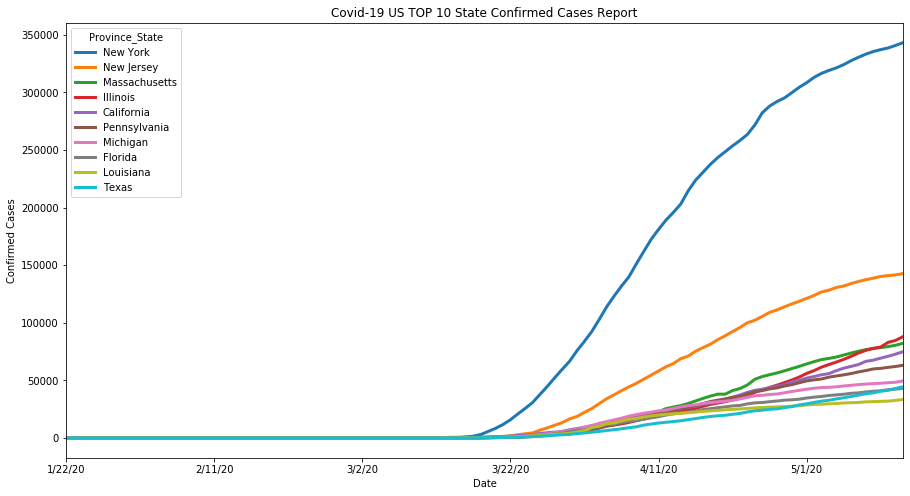

In [38]:
top10 = confirmed.groupby('Province_State')[time_feature].agg('sum').sum(axis=1).sort_values(ascending=False).head(10).keys()
confirmed_ts = confirmed.groupby('Province_State')[time_feature].agg('sum').transpose()[top10]

confirmed_ts.plot(figsize=(15,8), linewidth=3)
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.title('Covid-19 US TOP 10 State Confirmed Cases Report')
plt.show()

In [64]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

confirmed_ts_total = confirmed[time_feature].sum(axis=0)
death_ts_total = deaths[time_feature].sum(axis=0)

ts = pd.concat([confirmed_ts_total, death_ts_total], axis=1)
ts.columns = ['Confirmed', 'Deaths']
ts.index = pd.to_datetime(ts.index)
ts_daily = ts - ts.shift(1)
ts_daily.fillna(0, inplace=True)

confirmed_ts_df = go.Scatter(x=ts_daily.index,
                             y=ts_daily.Confirmed,
                             line=go.scatter.Line(color='blue', width = 3),
                             opacity=0.8,
                             name='Confirmed')


deaths_ts_df = go.Scatter(x=ts_daily.index,
                         y=ts_daily.Deaths,
                         line=go.scatter.Line(color='red', width = 3),
                         opacity=0.8,
                         name='Deaths')

layout = go.Layout(height=600, width=800,
                   title='2019 Covid-19 US Daily Cases Report',
                   # Same x and first y
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Cases Numbers', color='black'),
                   # Add a second yaxis to the right of the plot
                   yaxis2=dict(title='Deahts', color='red', overlaying='y', side='right'))

fig = go.Figure(data=[confirmed_ts_df, deaths_ts_df], layout=layout)

fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)'})

iplot(fig)

### Interactive Map

In [42]:
geo = pd.read_csv('uszips.csv').groupby('county_fips')[['lat', 'lng']].agg('mean').reset_index()
geo.columns = ['FIPS', 'lat', 'lng']

temp = data[['FIPS', 'County', 'State', 'Confirmed']]
temp = pd.merge(temp, geo, on=['FIPS'], how='inner')
temp['text'] = temp['County'] + ', ' + temp['State'] + '<br>' + temp['Confirmed'].astype(str) + ' confirmed'

limits = [(0,10),(11,100),(101,500),(501,1000),(1001,5000)]
colors = ["lightgrey","royalblue","lightseagreen","orange","red"]
cities = []
scale = 50

fig = go.Figure()

for i in range(len(limits)):
    lim = limits[i]
    df_sub = temp[lim[0]:lim[1]]
    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = df_sub['lng'],
        lat = df_sub['lat'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['Confirmed']/scale,
            color = colors[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1])))

fig.update_layout(
        title_text = '2019 US Covid-19 Confirmed Cases Map',
        showlegend = True,
        geo = dict(
            scope = 'usa',
            landcolor = 'rgb(217, 217, 217)',
        )
    )

fig.show()

In [59]:
from urllib.request import urlopen
import json

state_id = pd.read_csv('uszips.csv')[['state_id', 'state_name']].set_index('state_name').drop_duplicates()
df = data.groupby('State').agg('sum')[['Confirmed']]
df = pd.concat([df, state_id], axis=1, sort=False)

fig = go.Figure(data=go.Choropleth(
    locations=df.state_id, # Spatial coordinates
    z = df.Confirmed.astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = 'Confirmed Cases'
))

fig.update_layout(
    title_text = 'COVID-19 Confirmed Cased by State',
    geo_scope='usa')

fig.show()

### Dashboard

In [11]:
# import dash
# import dash_core_components as dcc
# import dash_html_components as html

# app = dash.Dash()
# app.layout = html.Div([
#     dcc.Graph(figure=fig)
# ])

# app.run_server(debug=True, use_reloader=False)  # Turn off reloader if inside Jupyter

Running on http://127.0.0.1:8050/
Debugger PIN: 168-079-258
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


## Time Series Forecasting

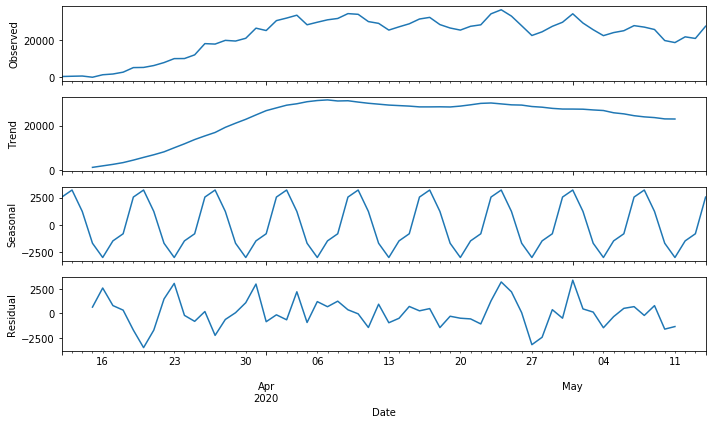

In [65]:
from pylab import rcParams

rcParams['figure.figsize'] = 10, 6
decomposition = sm.tsa.seasonal_decompose(x.Confirmed[50:], model='additive')
fig = decomposition.plot()
plt.show()

In [27]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(i[0], i[1], i[2], 7) for i in list(itertools.product(p, d, q))]
best_results = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(x.Confirmed[50:], order=param, seasonal_order=param_seasonal,
                                            enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()

            if best_results == []:
                best_results = [param, param_seasonal, results.aic]
            elif best_results[2] > results.aic:
                best_results = [param, param_seasonal, results.aic]
        except:
            continue

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Pyth

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\s

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jay48\AppData\Roaming\Python\Python37\site-p

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Pyth

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jay48\AppData\Roaming\Python\Python

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jay48\AppData\Roaming\Python\Python37\site-p

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jay48\AppData\Roaming\Python\Python

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jay48\AppData\Roaming\Python\Python37\site-p

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jay48\AppData\Roaming\Python\Python

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jay48\AppData\Roaming\Python\Python37\site-p

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\jay48\AppData\Roaming\Python\Python

In [28]:
mod = sm.tsa.statespace.SARIMAX(x.Confirmed[50:], order=best_results[0], seasonal_order=best_results[1],
                                enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

C:\Users\jay48\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1563      0.229     -5.056      0.000      -1.604      -0.708
ar.L2         -0.5949      0.232     -2.566      0.010      -1.049      -0.140
ar.S.L7       -0.5478      0.198     -2.769      0.006      -0.935      -0.160
ar.S.L14      -0.5993      0.227     -2.636      0.008      -1.045      -0.154
ma.S.L7       -1.0101      0.276     -3.657      0.000      -1.551      -0.469
sigma2      3.727e+06   7.16e-08    5.2e+13      0.000    3.73e+06    3.73e+06


[(2, 2, 0), (2, 2, 1, 7), 592.5361384897403]


<Figure size 432x288 with 0 Axes>

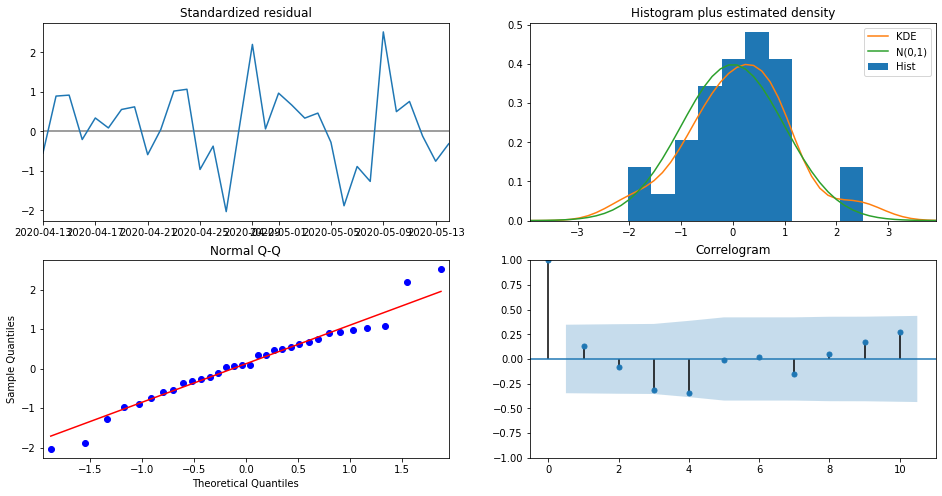

In [32]:
print(best_results)
plt.figure(figsize=(6,4))
fig = results.plot_diagnostics(figsize=(16, 8))
plt.show()

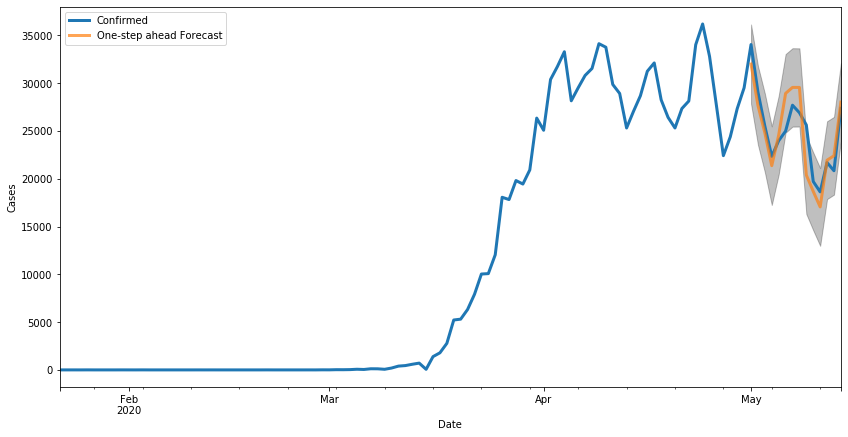

In [74]:
pred_start = ts_daily.index[-14]
pred = results.get_prediction(start=pred_start, dynamic=False)
pred_ci = pred.conf_int()

ax = x.plot(label='observed', linewidth=3)
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7), linewidth=3)
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Cases')
plt.legend()
plt.show()

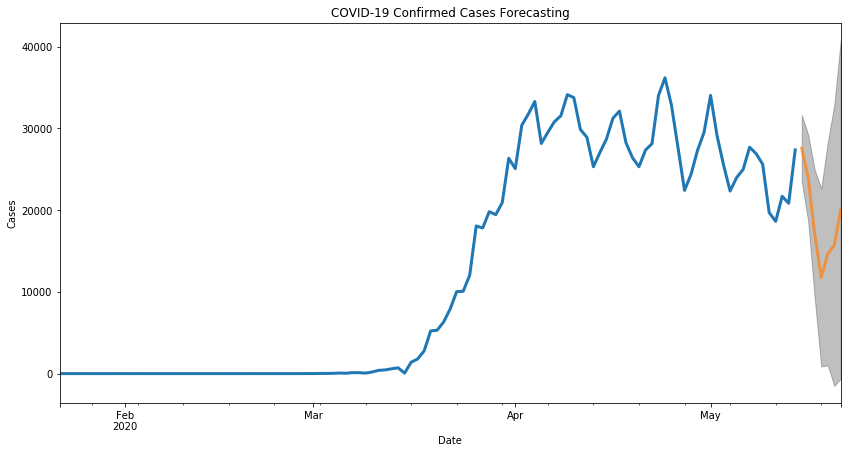

In [72]:
pred = results.get_forecast(steps=7)
pred_ci = pred.conf_int()

ax = ts_daily.Confirmed.plot(linewidth=3)
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7), linewidth=3)
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('COVID-19 Confirmed Cases Forecasting')
plt.show()

In [7]:
df = pd.read_csv('../../../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us/05-21-2020.csv')
df.head()

,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,Testing_Rate,Hospitalization_Rate
0,Alabama,US,2020-05-22 02:36:57,32.3182,-86.9023,13288,529,NaN,12759.0,1,271.007519,170739.0,1528.0,3.981036,84000001,USA,3482.205954,11.499097
1,Alaska,US,2020-05-22 02:36:57,61.3707,-152.4044,401,10,356.0,35.0,2,54.815493,39545.0,NaN,2.493766,84000002,USA,5405.682494,NaN
2,American Samoa,US,2020-05-22 02:36:57,-14.2710,-170.1320,0,0,NaN,0.0,60,0.000000,124.0,NaN,NaN,16,ASM,222.857246,NaN
3,Arizona,US,2020-05-22 02:36:57,33.7298,-111.4312,15348,764,3872.0,10712.0,4,210.861337,171627.0,1830.0,4.977847,84000004,USA,2357.929289,11.923378
4,Arkansas,US,2020-05-22 02:36:57,34.9697,-92.3731,5458,110,3915.0,1433.0,5,180.859990,99276.0,535.0,2.015390,84000005,USA,3289.676864,9.802125
